In [16]:

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
# Read the data
edges_df = pd.read_csv('../Data/edges.csv')
nodes_df = pd.read_csv('../Data/nodes.csv')
# Import nltk for lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
# Step 1: Get top 1000 artists by popularity
top_artists = nodes_df.nlargest(1000, 'popularity')

# Define the top 10 genres for classification
top_genres = {
    'pop': ['pop', 'k-pop', 'j-pop', 'cantopop', 'mandopop', 'synthpop', 'electropop'],
    'rock': ['rock', 'hard rock', 'punk rock', 'alternative rock', 'indie rock', 'classic rock'],
    'hip-hop': ['hip hop', 'rap', 'trap', 'gangsta rap', 'alternative hip hop'],
    'edm': ['edm', 'electronic', 'house', 'techno', 'dubstep', 'trance'],
    'r&b': ['r&b', 'soul', 'neo soul', 'funk'],
    'country': ['country', 'country pop', 'outlaw country'],
    'jazz': ['jazz', 'bebop', 'swing', 'cool jazz', 'fusion'],
    'classical': ['classical', 'orchestral', 'chamber music', 'baroque', 'romantic', 'symphony'],
    'latin': ['latin', 'reggaeton', 'salsa', 'bachata', 'latin pop'],
    'reggae': ['reggae', 'dub', 'dancehall']
}

# Step 2: Function to map genres to the top genres list
def map_to_top_genres(genre_str):
    if isinstance(genre_str, str):
        # Convert string to list format
        genre_list = [g.strip().strip("'") for g in genre_str.strip('[]').split(',')]
    elif isinstance(genre_str, list):
        # Directly assign if already a list
        genre_list = genre_str
    else:
        return []
    
    mapped_genres = set()
    for genre in genre_list:
        for top_genre, subgenres in top_genres.items():
            if any(sub in genre.lower() for sub in subgenres):
                mapped_genres.add(top_genre)
    return list(mapped_genres) if mapped_genres else []

# Apply the genre mapping function to top 1000 artists
top_artists['cleaned_genres'] = top_artists['genres'].apply(map_to_top_genres)
# Remove artists with empty genre lists
top_artists = top_artists[top_artists['cleaned_genres'].apply(len) > 0]

# Step 3: Function to expand 'chart_hits' into a list of dictionaries
def expand_chart_hits(chart_hits_str):
    if pd.isna(chart_hits_str) or chart_hits_str == '[]':
        return []
    
    try:
        chart_hits = ast.literal_eval(chart_hits_str)
        
        expanded = []
        for entry in chart_hits:
            country, hit_number = entry.replace("(", "").replace(")", "").split()
            expanded.append({
                'country_code': country,
                'hit_number': int(hit_number)
            })
        return expanded
    except Exception as e:
        print(f"Error processing chart hits: {e}")
        return []

# Step 4: Expand and aggregate chart hits data
expanded_hits = []
for idx, row in top_artists.iterrows():
    chart_data = expand_chart_hits(row['chart_hits'])
    for hit in chart_data:
        expanded_hits.append({
            'spotify_id': row['spotify_id'],
            'country_code': hit['country_code'],
            'hit_number': hit['hit_number']
        })

# Create a DataFrame for expanded chart hits
expanded_hits_df = pd.DataFrame(expanded_hits)

# Step 5: Aggregate total hits and number of countries for each artist
grouped_hits = expanded_hits_df.groupby('spotify_id').agg(
    total_hits=('hit_number', 'sum'), 
    num_countries=('country_code', 'nunique')
).reset_index()

# Merge aggregated hits data back into top_artists
top_artists = top_artists.merge(grouped_hits, on='spotify_id', how='left')
# Remove any artist with missing values in chart hits
top_artists = top_artists.dropna(subset=['total_hits', 'num_countries'])


# Step 6: Sort by total hits and get top 100 artists
top_artists = top_artists.sort_values(by='popularity', ascending=False)
top_artists = top_artists.head(100)

# Step 7: Remove outliers for numeric columns using 95% confidence interval
numeric_columns = ['followers', 'popularity']
for column in numeric_columns:
    # Calculate Q1, Q3 and IQR
    Q1 = top_artists[column].quantile(0.025)  # 2.5th percentile for 95% CI
    Q3 = top_artists[column].quantile(0.975)  # 97.5th percentile for 95% CI
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    top_artists = top_artists[
        (top_artists[column] >= lower_bound) & 
        (top_artists[column] <= upper_bound)
    ]

top_artists

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dominusdeorum/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dominusdeorum/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,spotify_id,name,followers,popularity,genres,chart_hits,cleaned_genres,total_hits,num_countries
0,4q3ewBCX7sLwd24euuV69X,Bad Bunny,55669387.0,100,"['reggaeton', 'trap latino']","['us (76)', 'gb (1)', 'ar (91)', 'au (2)', 'at...","[reggae, latin, hip-hop]",2122.0,71.0
1,3TVXtAsR1Inumwj472S9r4,Drake,66852536.0,95,"['canadian hip hop', 'canadian pop', 'hip hop'...","['us (190)', 'gb (163)', 'ar (18)', 'au (148)'...","[hip-hop, pop]",5005.0,71.0
2,06HL4z0CvFAxyc27GXpf02,Taylor Swift,58554324.0,94,['pop'],"['us (136)', 'gb (115)', 'ar (24)', 'au (110)'...",[pop],3104.0,70.0
3,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,49387909.0,93,"['canadian contemporary r&b', 'canadian pop', ...","['us (81)', 'gb (74)', 'ar (23)', 'au (76)', '...","[pop, r&b]",3714.0,71.0
4,6KImCVD70vtIoJWnq6nGn3,Harry Styles,23284667.0,91,['pop'],"['us (35)', 'gb (35)', 'ar (23)', 'au (35)', '...",[pop],1487.0,71.0
...,...,...,...,...,...,...,...,...,...
107,181bsRPaVXVlUKXrxwZfHK,Megan Thee Stallion,7034241.0,82,"['dance pop', 'houston rap', 'pop', 'rap', 'tr...","['us (26)', 'gb (6)', 'ar (1)', 'au (6)', 'at ...","[hip-hop, pop]",295.0,67.0
108,6Xgp2XMz1fhVYe7i6yNAax,Trippie Redd,7909088.0,82,"['melodic rap', 'rap', 'trap']","['us (78)', 'gb (7)', 'au (5)', 'at (1)', 'be ...",[hip-hop],291.0,44.0
112,1DxLCyH42yaHKGK3cl5bvG,Maria Becerra,3091269.0,82,"['latin pop', 'pop argentino']","['ar (21)', 'bo (7)', 'cl (6)', 'co (1)', 'cr ...","[latin, pop]",94.0,17.0
110,7n2Ycct7Beij7Dj7meI4X0,TWICE,14818846.0,82,"['k-pop', 'k-pop girl group']","['us (1)', 'au (2)', 'bo (1)', 'bg (2)', 'ca (...",[pop],263.0,26.0


In [17]:
artist_collabs = pd.concat([edges_df['id_0'], edges_df['id_1']]).value_counts().reset_index()
artist_collabs.columns = ['spotify_id', 'collab_count']

top_artists_with_collabs = top_artists.merge(artist_collabs, on='spotify_id', how='left')
top_artists_with_collabs['collab_count'] = top_artists_with_collabs['collab_count'].fillna(0)
top_artists_with_collabs = top_artists_with_collabs[
    (top_artists_with_collabs['collab_count'] >= 
     top_artists_with_collabs['collab_count'].mean() - 2*top_artists_with_collabs['collab_count'].std()) &
    (top_artists_with_collabs['collab_count'] <= 
     top_artists_with_collabs['collab_count'].mean() + 2*top_artists_with_collabs['collab_count'].std())
]
top_artists_with_collabs

,spotify_id,name,followers,popularity,genres,chart_hits,cleaned_genres,total_hits,num_countries,collab_count
0,4q3ewBCX7sLwd24euuV69X,Bad Bunny,55669387.0,100,"['reggaeton', 'trap latino']","['us (76)', 'gb (1)', 'ar (91)', 'au (2)', 'at...","[reggae, latin, hip-hop]",2122.0,71.0,128.0
1,3TVXtAsR1Inumwj472S9r4,Drake,66852536.0,95,"['canadian hip hop', 'canadian pop', 'hip hop'...","['us (190)', 'gb (163)', 'ar (18)', 'au (148)'...","[hip-hop, pop]",5005.0,71.0,111.0
2,06HL4z0CvFAxyc27GXpf02,Taylor Swift,58554324.0,94,['pop'],"['us (136)', 'gb (115)', 'ar (24)', 'au (110)'...",[pop],3104.0,70.0,35.0
3,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,49387909.0,93,"['canadian contemporary r&b', 'canadian pop', ...","['us (81)', 'gb (74)', 'ar (23)', 'au (76)', '...","[pop, r&b]",3714.0,71.0,71.0
4,6KImCVD70vtIoJWnq6nGn3,Harry Styles,23284667.0,91,['pop'],"['us (35)', 'gb (35)', 'ar (23)', 'au (35)', '...",[pop],1487.0,71.0,0.0
...,...,...,...,...,...,...,...,...,...,...
95,181bsRPaVXVlUKXrxwZfHK,Megan Thee Stallion,7034241.0,82,"['dance pop', 'houston rap', 'pop', 'rap', 'tr...","['us (26)', 'gb (6)', 'ar (1)', 'au (6)', 'at ...","[hip-hop, pop]",295.0,67.0,68.0
96,6Xgp2XMz1fhVYe7i6yNAax,Trippie Redd,7909088.0,82,"['melodic rap', 'rap', 'trap']","['us (78)', 'gb (7)', 'au (5)', 'at (1)', 'be ...",[hip-hop],291.0,44.0,125.0
97,1DxLCyH42yaHKGK3cl5bvG,Maria Becerra,3091269.0,82,"['latin pop', 'pop argentino']","['ar (21)', 'bo (7)', 'cl (6)', 'co (1)', 'cr ...","[latin, pop]",94.0,17.0,31.0
98,7n2Ycct7Beij7Dj7meI4X0,TWICE,14818846.0,82,"['k-pop', 'k-pop girl group']","['us (1)', 'au (2)', 'bo (1)', 'bg (2)', 'ca (...",[pop],263.0,26.0,7.0


In [18]:
# Create a new dataframe with exploded genres
genre_artist_df = pd.DataFrame({
    'artist_name': top_artists_with_collabs['name'].repeat(top_artists_with_collabs['cleaned_genres'].str.len()),
    'genre': [genre for genres in top_artists_with_collabs['cleaned_genres'] for genre in genres]
})

# Display the first few rows to verify the structure
print("\nFirst few rows of the genre-artist relationship:")
print(genre_artist_df.head(10))

# Print total number of genre-artist relationships
print(f"\nTotal number of genre-artist relationships: {len(genre_artist_df)}")



First few rows of the genre-artist relationship:
    artist_name    genre
0     Bad Bunny   reggae
0     Bad Bunny    latin
0     Bad Bunny  hip-hop
1         Drake  hip-hop
1         Drake      pop
2  Taylor Swift      pop
3    The Weeknd      pop
3    The Weeknd      r&b
4  Harry Styles      pop
5           BTS      pop

Total number of genre-artist relationships: 154



Average collaborations by genre:
     genre  avg_collabs  artist_count
1      edm   133.333333             3
6   reggae   124.615385            13
3    latin   111.888889            18
2  hip-hop   106.958333            48
4      pop    83.181818            55
5      r&b    80.625000             8
7     rock    28.000000             8
0  country     9.000000             1


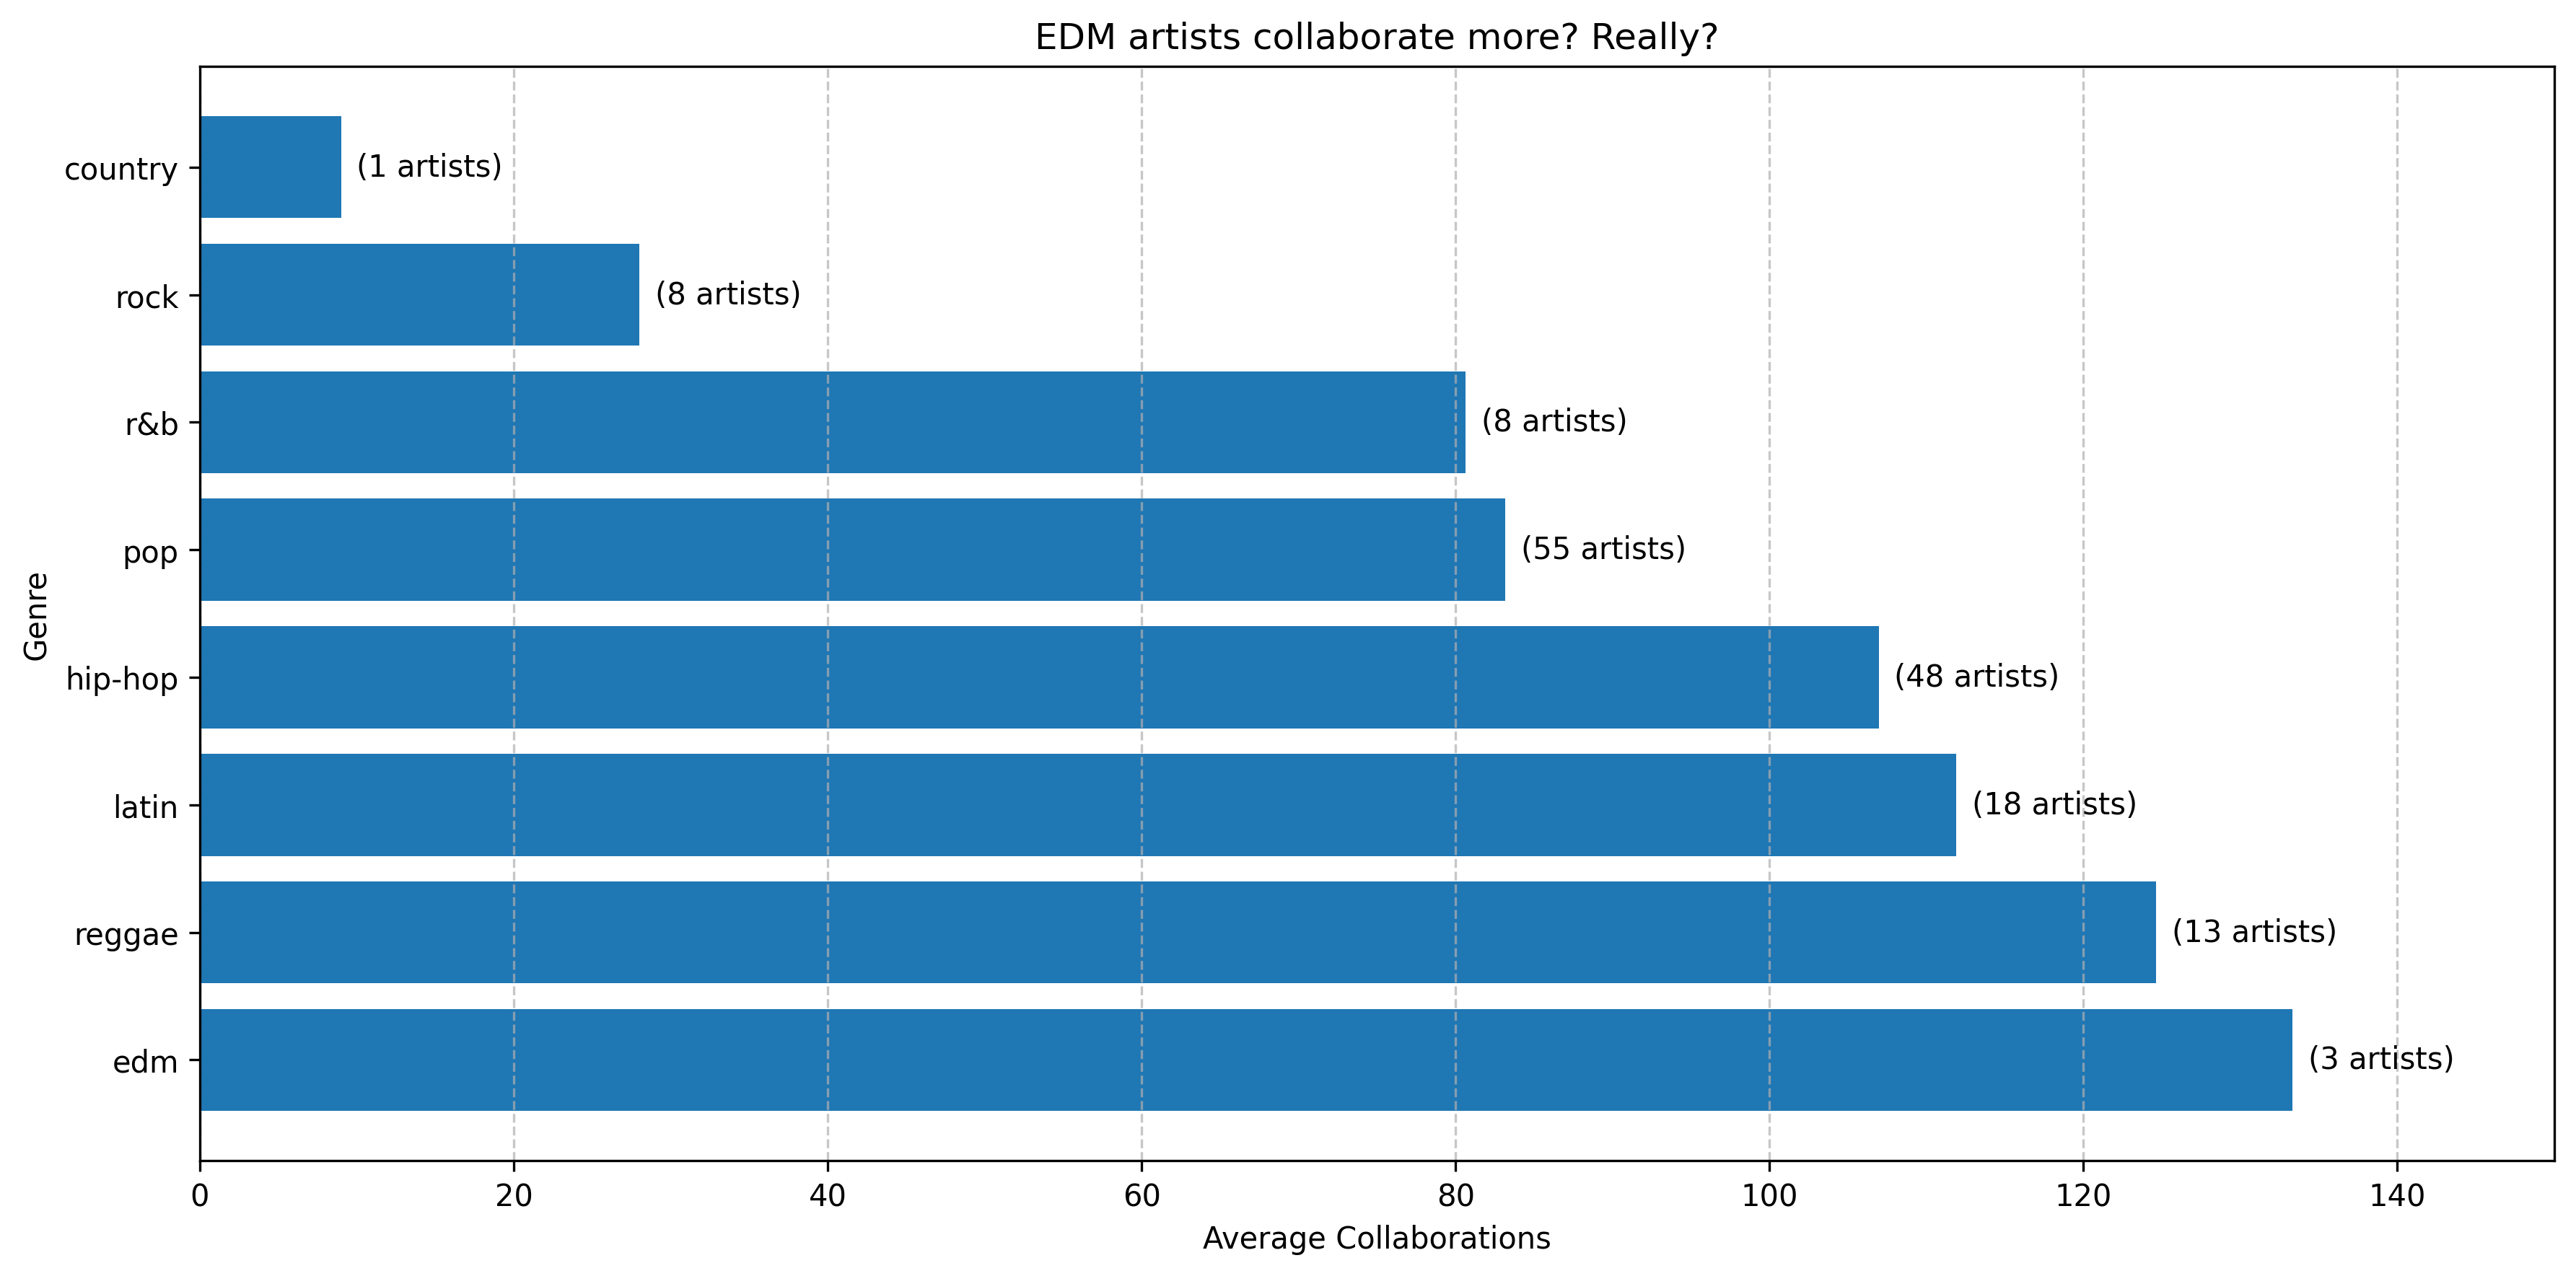

In [22]:
# Merge collaboration counts with genre data
genre_collab_df = genre_artist_df.merge(
    top_artists_with_collabs[['name', 'collab_count']], 
    left_on='artist_name',
    right_on='name'
)

# Calculate average collaboration count per genre
genre_collab_stats = genre_collab_df.groupby('genre').agg({
    'collab_count': ['mean', 'count']
}).reset_index()

# Flatten column names
genre_collab_stats.columns = ['genre', 'avg_collabs', 'artist_count']

# Sort by average collaborations (descending)
genre_collab_stats = genre_collab_stats.sort_values('avg_collabs', ascending=False)

# Display results
print("\nAverage collaborations by genre:")
print(genre_collab_stats)

# Create a horizontal bar plot
plt.figure(figsize=(12, 6), dpi=300)
plt.barh(genre_collab_stats['genre'], genre_collab_stats['avg_collabs'])
plt.xlim(0, 150)
plt.grid(axis='x', linestyle='--', alpha=0.7)


# Add artist count labels
for i, v in enumerate(genre_collab_stats['artist_count']):
    plt.text(genre_collab_stats['avg_collabs'].iloc[i] + 1, i, f'({v} artists)', ha='left', va='center')

plt.title('EDM artists collaborate more? Really?')
plt.xlabel('Average Collaborations')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


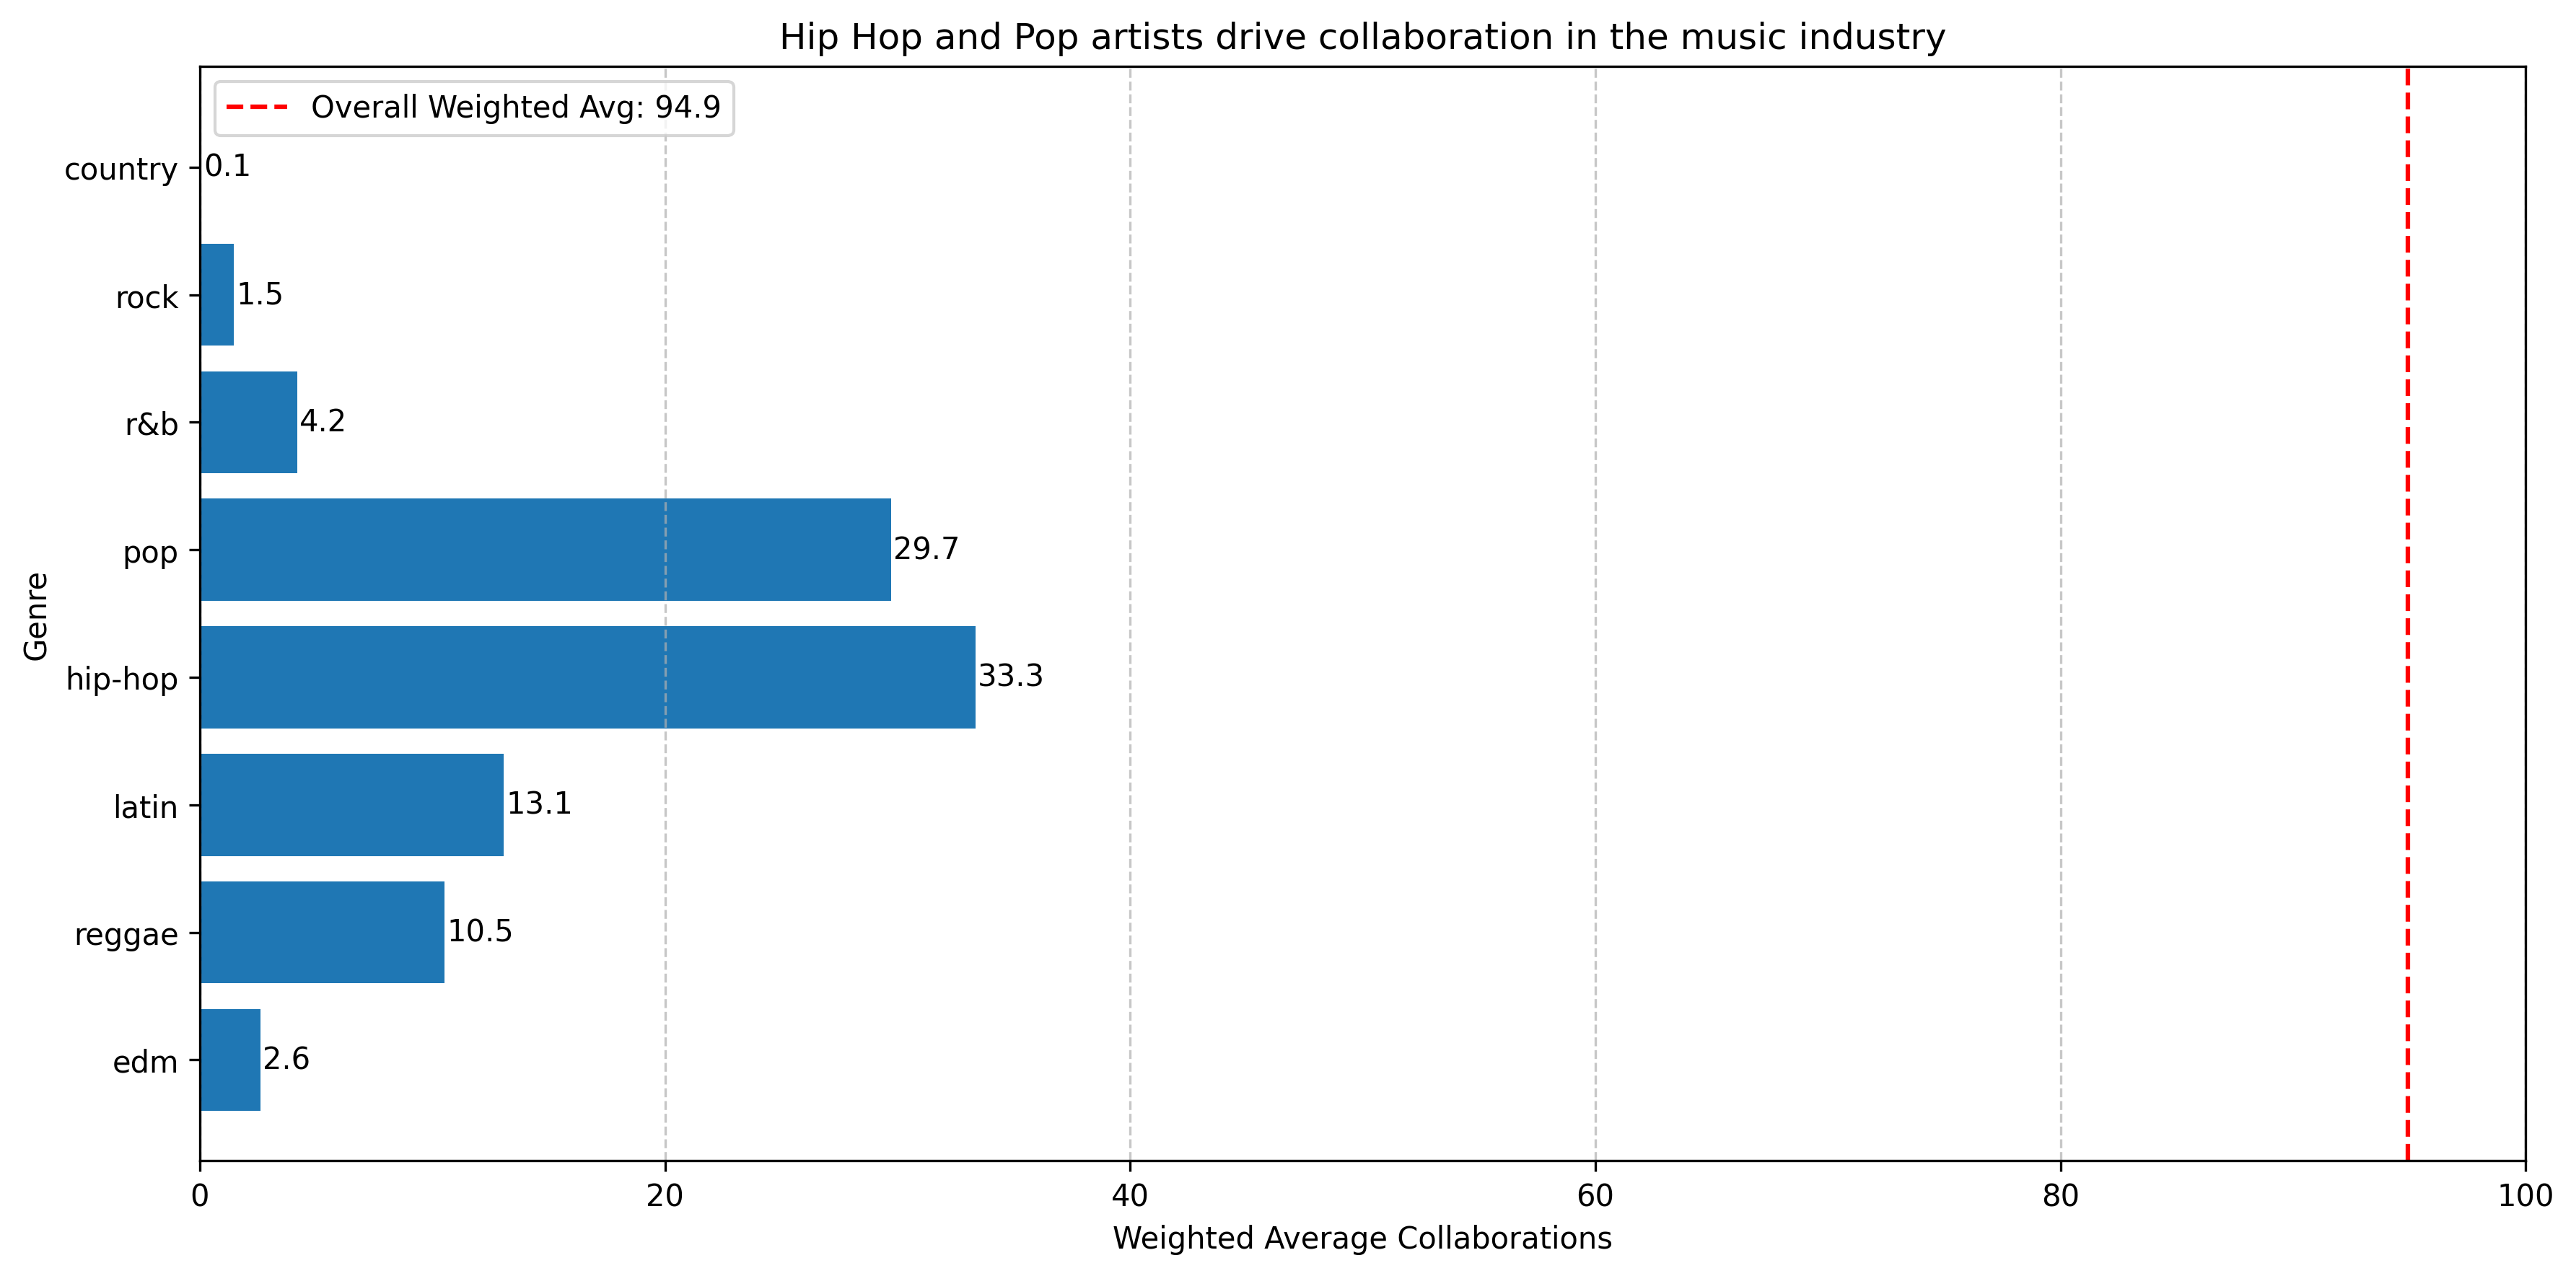

In [24]:
# Calculate weighted average of collaborations by genre
weighted_avg = (genre_collab_stats['avg_collabs'] * genre_collab_stats['artist_count']).sum() / genre_collab_stats['artist_count'].sum()

# Create horizontal bar chart of weighted collaborations
plt.figure(figsize=(12, 6), dpi=300)
plt.barh(genre_collab_stats['genre'], 
         genre_collab_stats['avg_collabs'] * genre_collab_stats['artist_count'] / genre_collab_stats['artist_count'].sum())
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.title('Hip Hop and Pop artists drive collaboration in the music industry')
plt.ylabel('Genre')
plt.xlabel('Weighted Average Collaborations')

# Add weighted average labels at end of each bar
for i, v in enumerate(genre_collab_stats['avg_collabs'] * genre_collab_stats['artist_count'] / genre_collab_stats['artist_count'].sum()):
    plt.text(v + 0.1, i, f'{v:.1f}', va='center')

# Add vertical line for overall weighted average
plt.axvline(x=weighted_avg, color='r', linestyle='--', label=f'Overall Weighted Avg: {weighted_avg:.1f}')
plt.legend()

plt.tight_layout()
plt.show()
